# Previsione dell'affidabilità creditizia per il rilascio della carta di credito

In [1]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Path to the zip file
zip_file_path = 'credit_card_approval.zip'

# Current working directory
csv_directory = os.getcwd() 

# Extract the files from the zip folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_files=zip_ref.extractall()


# Loop through each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        file_path = os.path.join(csv_directory, filename)
        if 'df1' not in globals():
            df1 = pd.read_csv(file_path) 
        else:
            df2 = pd.read_csv(file_path)

# zipfile.ZipFile: open a zip file
# ZipFile.extractall: Extract all members from the archive to the current working directory.
# os.listdir(path): Return a list containing the names of the entries in the directory given by path. 
# os.path.join(path, *paths): Join one or more path segments intelligently. The return value is the concatenation of path and all members of *paths

## PRE-PROCESSING

In [3]:
df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
df2.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### DUPLICATES: df1

In [5]:
df1.groupby('ID').size().max()

2

#### df1 contiene IDs duplicati da rimuovere

In [6]:
df1=df1.drop_duplicates() # remove rows with same values

In [7]:
df1.groupby('ID').size().max()

2

#### Ci sono IDs duplicati con diversi valori delle features

In [8]:
id_counts = df1.groupby('ID').size()  # the 'ID' becomes the label
id_counts.head()

ID
5008804    1
5008805    1
5008806    1
5008808    1
5008809    1
dtype: int64

In [9]:
multiple_occurrences = id_counts[id_counts > 1].index.tolist() # get the labels when counts > 1 and convert result to list
print("ID values with more than one occurrence:", multiple_occurrences)

ID values with more than one occurrence: [7022197, 7022327, 7023108, 7023651, 7024111, 7036518, 7045794, 7045885, 7046068, 7050948, 7052783, 7052812, 7053557, 7089090, 7090931, 7091721, 7099881, 7135270, 7137299, 7154598, 7154819, 7155150, 7174719, 7207977, 7213374, 7243768, 7282535, 7317997, 7372589, 7416167, 7576316, 7602432, 7603224, 7618285, 7636389, 7636756, 7702238, 7702516, 7742298, 7742853, 7743418, 7744386, 7772847, 7833087, 7836711, 7836971, 7838075]


In [10]:
df1[df1['ID']==7022197]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0


#### Osserviamo che due persone diverse (donna e uomo) hanno lo stesso 'ID'

In [11]:
boolean_mask=df1['ID'].isin(multiple_occurrences)

In [12]:
df1=df1[~boolean_mask] # apply the contrary of boolean_mask

In [13]:
df1.shape

(438463, 18)

In [14]:
df1.groupby('ID').size().max()

1

#### Abbiamo eliminato da 'df1' le osservazioni con stesso 'ID' che hanno diversi valori delle altre features

In [15]:
boolean_mask = df1['ID'].isin(df2['ID']) # check if each df1 ID is contained in df2 IDs

In [16]:
boolean_mask.shape

(438463,)

In [17]:
boolean_mask.head()

0    True
1    True
2    True
3    True
4    True
Name: ID, dtype: bool

In [18]:
df1.shape

(438463, 18)

#### Manteniamo soltanto gli IDs di df1 che avranno dei valori in df2

In [19]:
df1=df1[boolean_mask]

In [20]:
df1.shape

(36457, 18)

### MISSING VALUES: df1

In [21]:
df1.isna().sum()/df1.shape[0]*100 # normalized count of missing values

ID                      0.000000
CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
FLAG_OWN_REALTY         0.000000
CNT_CHILDREN            0.000000
AMT_INCOME_TOTAL        0.000000
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
FLAG_MOBIL              0.000000
FLAG_WORK_PHONE         0.000000
FLAG_PHONE              0.000000
FLAG_EMAIL              0.000000
OCCUPATION_TYPE        31.058507
CNT_FAM_MEMBERS         0.000000
dtype: float64

#### La variabile 'OCCUPATION_TYPE' contiene molti valori mancanti (31 %)
#### Poichè abbiamo la variabile 'NAME_INCOME_TYPE' decido di eliminare la variabile 'OCCUPATION_TYPE'

In [22]:
df1=df1.drop('OCCUPATION_TYPE',axis=1)

In [23]:
df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


### STATISTICS: df1

In [24]:
df1.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [25]:
for column_index in range(1,df1.shape[1]-1):
    var=df1.iloc[:, column_index]
    unique_values=var.unique()
    num_unique_values=len(unique_values)
    column_name = df1.columns[column_index]
    print(f"\nNumber of unique values for the variable {column_name}: {num_unique_values}")
    if num_unique_values<=10:
        print(f"Values: {unique_values}")
    else:
        print("More than 10 possible values")


Number of unique values for the variable CODE_GENDER: 2
Values: ['M' 'F']

Number of unique values for the variable FLAG_OWN_CAR: 2
Values: ['Y' 'N']

Number of unique values for the variable FLAG_OWN_REALTY: 2
Values: ['Y' 'N']

Number of unique values for the variable CNT_CHILDREN: 9
Values: [ 0  1  3  2  4  5 14 19  7]

Number of unique values for the variable AMT_INCOME_TOTAL: 265
More than 10 possible values

Number of unique values for the variable NAME_INCOME_TYPE: 5
Values: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

Number of unique values for the variable NAME_EDUCATION_TYPE: 5
Values: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Number of unique values for the variable NAME_FAMILY_STATUS: 5
Values: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

Number of unique values for the variable NAME_HOUSING_TYPE: 6
Values: ['Rented apartment' 'House / apartment' '

#### Variabili qualitative non ordinali: 'ID','NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'
#### Variabili qualitative ordinali: 'NAME_EDUCATION_TYPE', 'MONTHS_BALANCE'
#### Variabili qualitative booleane: 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'
#### Variabili quantitative discrete: 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS	'
#### Variabili quantitative continue: 'AMT_INCOME_TOTAL'

#### Osservo che la variabile 'FLAG_MOBIL' ha un solo valore e inoltre non risulta apparentemente rilevante per l'analisi, per cui decido di rimuoverla

In [26]:
df1=df1.drop("FLAG_MOBIL",axis=1)
df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0


#### Osservo che la variabile 'CNT_CHILDREN' ha valori alti inusuali, per cui ne osservo la distribuzione 

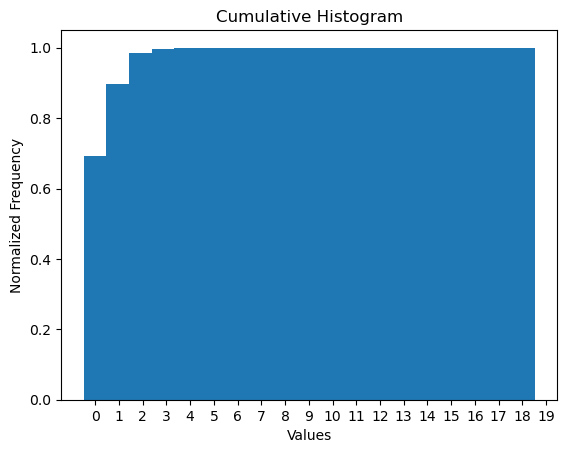

Min: 0 
Max: 19


In [27]:
# Create histogram
bins_number=max(df1["CNT_CHILDREN"])-min(df1["CNT_CHILDREN"])+1
plt.hist(df1["CNT_CHILDREN"], density=True, cumulative=True, bins=bins_number, align='left') 

# Add labels and title
plt.xlabel('Values')
x_ticks=np.arange(min(df1["CNT_CHILDREN"]), max(df1["CNT_CHILDREN"]) + 1, 1)
plt.xticks(x_ticks)
plt.ylabel('Normalized Frequency')
plt.title('Cumulative Histogram')

# Show plot
plt.show()

# Min and max values
print(f'Min: {df1["CNT_CHILDREN"].min()} \nMax: {df1["CNT_CHILDREN"].max()}')

#### Osserviamo che quasi il 100 % delle persone ha al più 3 figli, per cui manteniamo questi dati

#### Il reddito annuale, che suppongo essere in euro, varia da 27 k a oltre 1 milione e mezzo, indicando soggetti con redditi da buoni a molto alti e comunque plausibili

In [28]:
min_age=abs(df1["DAYS_BIRTH"]).min()/365
max_age=abs(df1["DAYS_BIRTH"]).max()/365
print(f"The minimum and maximum ages are around: {round(min_age)}, {round(max_age)}")

The minimum and maximum ages are around: 21, 69


#### L'età minima e massima sono plausibili; inoltre, l'età minima per avere una carta di credito in Italia è di 18 anni, quindi questo requisito è presente nei dati

In [29]:
"""

Function that checks if the date of birth is before the reference date for 
work

"""

def check_employment_variable_plausibility(days_employed,days_birth):
    
    days_birth=abs(days_birth)
    days_employed=abs(days_employed)
    
    boolean_mask = days_employed >= days_birth 
    
    if sum(boolean_mask) > 0:
        print("Attention! Some samples have incompatible 'DAYS_BIRTH' and 'DAYS_EMPLOYED' features!")
        
    else:
        boolean_mask=None
    
    return boolean_mask
        

In [30]:
days_employed,days_birth=df1["DAYS_EMPLOYED"],df1["DAYS_BIRTH"]
boolean_mask=check_employment_variable_plausibility(days_employed,days_birth)

Attention! Some samples have incompatible 'DAYS_BIRTH' and 'DAYS_EMPLOYED' features!


In [31]:
df1[boolean_mask].head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,1.0
76,5008884,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,0,0,0,1.0
160,5008974,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,0,0,0,2.0


#### Alcune osservazioni presentano una data di nascita successiva alla data da cui si inizia a lavorare/si smette di lavorare. Queste osservazioni vengono eliminate

In [32]:
if boolean_mask is not None:
    df1=df1[~boolean_mask]

In [33]:
sum((abs(df1["DAYS_BIRTH"]) - abs(df1["DAYS_EMPLOYED"]))/365 < 15)/df1.shape[0]*100

0.0

#### Non ci sono persone che hanno iniziato a lavorare prima dell'età minima in Italia (15 anni)

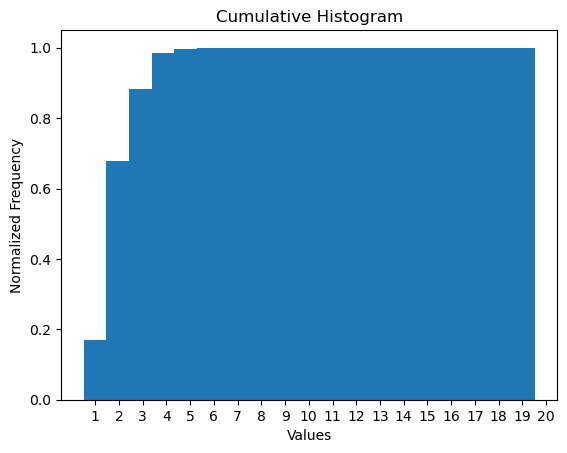

Min: 1 
Max: 20


In [34]:
# Create histogram
bins_number=max(df1["CNT_FAM_MEMBERS"])-min(df1["CNT_FAM_MEMBERS"])+1
plt.hist(df1["CNT_FAM_MEMBERS"], density=True, cumulative=True, bins=int(bins_number), align='left') 

# Add labels and title
plt.xlabel('Values')
x_ticks=np.arange(min(df1["CNT_FAM_MEMBERS"]), max(df1["CNT_FAM_MEMBERS"]) + 1, 1)
plt.xticks(x_ticks)
plt.ylabel('Normalized Frequency')
plt.title('Cumulative Histogram')

# Show plot
plt.show()

# Min and max values
print(f'Min: {int(df1["CNT_FAM_MEMBERS"].min())} \nMax: {int(df1["CNT_FAM_MEMBERS"].max())}')


#### Il numero di membri della famiglia 'CNT_FAM_MEMBERS' varia da un minimo di 1 a un massimo di 20. Quasi il 100 % delle persone ha un numero di membri pari o inferiore a 5, numero plausibile

### STATISTICS: df2

In [36]:
boolean_mask = df2['ID'].isin(df1['ID']) # check if each df2 ID is contained in df1 IDs

In [37]:
boolean_mask.shape

(1048575,)

In [38]:
boolean_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: ID, dtype: bool

In [39]:
df2.shape

(1048575, 3)

#### Mantengo soltanto gli IDs di df2 che avranno dei valori in df1

In [40]:
df2=df2[boolean_mask]

In [41]:
df2.describe()

,ID,MONTHS_BALANCE
count,6.497430e+05,649743.000000
mean,5.079218e+06,-19.343351
std,4.180550e+04,14.055767
min,5.008804e+06,-60.000000
25%,5.045230e+06,-29.000000
50%,5.078988e+06,-17.000000
75%,5.115669e+06,-8.000000
max,5.150487e+06,0.000000


In [207]:
abs(df2["MONTHS_BALANCE"].min())/12

5.0

#### I dati sono stati raccolti in un range di tempo che va da 0 mesi a 5 anni

In [43]:
df2.groupby("ID").size()

ID
5008804    16
5008805    15
5008806    30
5008808     5
5008809     5
           ..
5150482    18
5150483    18
5150484    13
5150485     2
5150487    30
Length: 30322, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1fbb391d1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fbb2558650>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fbb3abb050>],
 'medians': [<matplotlib.lines.Line2D at 0x1fbb3967a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fbb3974490>],
 'means': []}

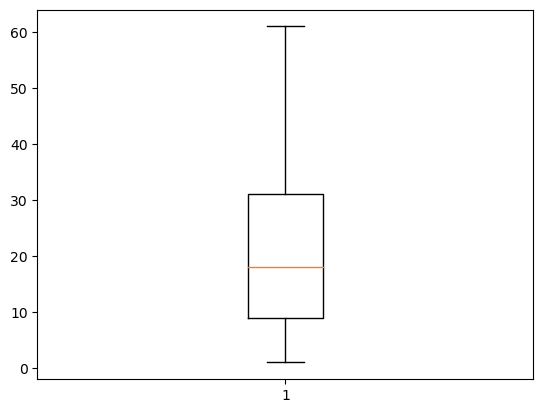

In [44]:
plt.boxplot(df2.groupby("ID").size())

In [45]:
df2.groupby("ID").size().min()

1

In [46]:
df2.groupby("ID").size().max()

61

#### Il numero di STATI della carta di credito non è uniforme sui vari IDs e varia da un minimo di 1 a un massimo di 61, con distribuzione come mostrata nel boxplot: circa 25 % degli IDs ha tra 1 e 10 STATI, circa il 50 % ha tra 10 e 30 STATI, il rimanente 25 % ha tra 30 e 61 STATI

#### SIGNIFICATO DEGLI STATI:
#### "PAST DUE" è un termine che include qualsiasi pagamento in ritardo, mentre "OVERDUE" indica specificamente che un pagamento è in ritardo di un periodo significativo oltre la sua scadenza.
#### "PAID OFF THAT MONTH": debiti erano presenti sulla tua carta di credito durante il mese, ma sono stati saldati.
#### "NO LOAN FOR THE MONTH": non c'era alcun debito sulla carta di credito in nessun momento durante il mese.

In [47]:
df2.head()

,ID,MONTHS_BALANCE,STATUS
92938,5008804,0,C
92939,5008804,-1,C
92940,5008804,-2,C
92941,5008804,-3,C
92942,5008804,-4,C


#### Creo una copia di df2 da modificare per definire l'output di ogni ID

In [48]:
df3=df2.copy()

#### Assegno i seguenti punteggi ai diversi stati:
#### 0: no loan for the month
#### 1: paid off that month
#### 2: 1-29 days past due
#### 3: 30-59 days past due
#### 4: 60-89 days overdue
#### 5: 90-119 days overdue
#### 6: 120-149 days overdue
#### 7: overdue or bad debts
#### Valori più bassi indicano un comportamento migliore; un valore pari a 0 indica l'assenza di debiti
#### Nota: tenere in considerazione che non tutti i soggetti hanno avuto lo stesso tempo di osservazione

In [49]:
status_mapping={'0':2,'1':3,'2':4,'3':5,'4':6,'5':7,'X':0,'C':1}
df3["STATUS"] = df3["STATUS"].map(status_mapping)

In [50]:
df3["STATUS"].unique()

array([1, 3, 2, 0, 4, 5, 7, 6], dtype=int64)

In [51]:
df3.head()

,ID,MONTHS_BALANCE,STATUS
92938,5008804,0,1
92939,5008804,-1,1
92940,5008804,-2,1
92941,5008804,-3,1
92942,5008804,-4,1


#### Mantengo solamente gli ID osservati per almeno 12 mesi

In [52]:
threshold = 12

In [53]:
id_counts = df3.groupby('ID').size()
id_counts

ID
5008804    16
5008805    15
5008806    30
5008808     5
5008809     5
           ..
5150482    18
5150483    18
5150484    13
5150485     2
5150487    30
Length: 30322, dtype: int64

In [54]:
valid_ids = id_counts[id_counts >= threshold].index
valid_ids

Int64Index([5008804, 5008805, 5008806, 5008810, 5008811, 5008825, 5008826,
            5008830, 5008831, 5008832,
            ...
            5150475, 5150476, 5150477, 5150478, 5150480, 5150481, 5150482,
            5150483, 5150484, 5150487],
           dtype='int64', name='ID', length=20627)

In [55]:
df3[df3["ID"]==5008805]

,ID,MONTHS_BALANCE,STATUS
92954,5008805,0,1
92955,5008805,-1,1
92956,5008805,-2,1
92957,5008805,-3,1
92958,5008805,-4,1
92959,5008805,-5,1
92960,5008805,-6,1
92961,5008805,-7,1
92962,5008805,-8,1
92963,5008805,-9,1


In [56]:
df3 = df3[df3['ID'].isin(valid_ids)]
df3.head()

,ID,MONTHS_BALANCE,STATUS
92938,5008804,0,1
92939,5008804,-1,1
92940,5008804,-2,1
92941,5008804,-3,1
92942,5008804,-4,1


In [57]:
df3["MEAN_STATUS"]= df3.groupby('ID')["STATUS"].transform("mean")
df3["MAX_STATUS"]= df3.groupby('ID')["STATUS"].transform("max")

In [58]:
df3.head()

,ID,MONTHS_BALANCE,STATUS,MEAN_STATUS,MAX_STATUS
92938,5008804,0,1,1.125,3
92939,5008804,-1,1,1.125,3
92940,5008804,-2,1,1.125,3
92941,5008804,-3,1,1.125,3
92942,5008804,-4,1,1.125,3


In [59]:
df3=df3.drop(["MONTHS_BALANCE","STATUS"],axis=1)

In [60]:
df3.drop_duplicates(subset='ID', inplace=True)

In [61]:
df3.head()

,ID,MEAN_STATUS,MAX_STATUS
92938,5008804,1.125000,3
92954,5008805,1.133333,3
92969,5008806,0.700000,2
93009,5008810,1.000000,2
93036,5008811,1.000000,2


#### Se lo stato massimo ottenuto è minore o uguale a 2 e se lo stato medio è minore o uguale a 1 (cioè se il valore di 2 è stato raggiunto al più una volta in un periodo maggiore o uguale a 12 mesi) , stabilisco che il soggetto appartiene alla classe 1 (SI' carta di credito)
#### In tutti gli altri casi stabilisco che il soggetto appartiene alla classe 0 (NO carta di credito)

In [62]:
df3.loc[(df3["MEAN_STATUS"] <= 1) & (df3["MAX_STATUS"] <= 2), "CLASS"] = 1

In [63]:
df3.loc[df3["MEAN_STATUS"] > 1, "CLASS"] = 0

In [64]:
df3.loc[df3["MAX_STATUS"] > 2, "CLASS"] = 0

In [65]:
df3.head()

,ID,MEAN_STATUS,MAX_STATUS,CLASS
92938,5008804,1.125000,3,0.0
92954,5008805,1.133333,3,0.0
92969,5008806,0.700000,2,1.0
93009,5008810,1.000000,2,1.0
93036,5008811,1.000000,2,1.0


In [66]:
df3.shape

(20627, 4)

In [67]:
df3["CLASS"].value_counts()/df3.shape[0]*100

0.0    79.575314
1.0    20.424686
Name: CLASS, dtype: float64

#### Il dataset è fortemente sbilanciato verso la classe negativa

### DATASET MERGE

In [68]:
df = pd.merge(df1, df3[["ID","CLASS"]], on='ID', how='inner')

In [69]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLASS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0,1.0
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,1.0
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,1.0


### TRAIN AND TEST SET CREATION

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X=df.drop(["ID","CLASS"],axis=1)

In [72]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0


In [73]:
y=df["CLASS"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### ENCODING

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#### LABEL ENCODING

In [76]:
education_mapping={"Lower secondary":1,"Secondary / secondary special":2,"Incomplete higher":3,"Higher education":4,"Academic degree":5}
X_train["NAME_EDUCATION_TYPE"]=X_train["NAME_EDUCATION_TYPE"].map(education_mapping)
X_test["NAME_EDUCATION_TYPE"]=X_test["NAME_EDUCATION_TYPE"].map(education_mapping)

In [77]:
gender_mapping={"F":1,"M":0}
X_train["CODE_GENDER"]=X_train["CODE_GENDER"].map(gender_mapping)
X_test["CODE_GENDER"]=X_test["CODE_GENDER"].map(gender_mapping)

In [78]:
car_mapping={"Y":1,"N":0}
X_train["FLAG_OWN_CAR"]=X_train["FLAG_OWN_CAR"].map(car_mapping)
X_test["FLAG_OWN_CAR"]=X_test["FLAG_OWN_CAR"].map(car_mapping)

In [79]:
realty_mapping={"Y":1,"N":0}
X_train["FLAG_OWN_REALTY"]=X_train["FLAG_OWN_REALTY"].map(realty_mapping)
X_test["FLAG_OWN_REALTY"]=X_test["FLAG_OWN_REALTY"].map(realty_mapping)

#### ONE HOT ENCODING

In [80]:
ohe = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(), ["NAME_INCOME_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"])
    ],
    remainder='passthrough' 
    )

In [81]:
X_train = ohe.fit_transform(X_train) 
X_test = ohe.transform(X_test) 

In [82]:
X_train[1,:]

array([ 0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        1.575e+05,  2.000e+00, -8.466e+03, -1.236e+03,  0.000e+00,
        0.000e+00,  0.000e+00,  1.000e+00])

### SCALING

#### STANDARDIZATION

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
ss=StandardScaler()

In [85]:
X_train_st=ss.fit_transform(X_train)
X_test_st=ss.transform(X_test)

#### NORMALIZATION

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
mms=MinMaxScaler()

In [88]:
X_train_norm=mms.fit_transform(X_train)
X_test_norm=mms.transform(X_test)

### MODELS METRICS

#### Ipotizzo che il modello permetta di fornire una carta di credito ai predetti negativi senza ulteriori analisi, e indichi tramite i predetti positivi verso chi effettuare ulteriori indagini prima di stabilire come procedere.
#### Di conseguenza, si vuole avere: 
#### 1) una bassa percentuale di persone che seppur inadeguate (falsi negativi) riceveranno la carta di credito
#### 2) una bassa percentuale di persone da analizzare ulteriormente (predetti positivi)
#### 3) una bassa percentuale di persone che, tra i predetti positivi è effettivamente positiva 

In [98]:
from sklearn.metrics import confusion_matrix, precision_score

In [102]:
import seaborn as sns

In [99]:
def plot_confusion_matrix(y_true,y_pred,labels=["Negative","Positive"]):

    cm=confusion_matrix(y_true,y_pred) 
    
    df_cm=pd.DataFrame(cm,index=labels,
                      columns=["Predicted"+labels[0],"Predicted"+labels[1]])
    sns.heatmap(df_cm,annot=True,fmt='d')

In [192]:
def evaluate_model(y_test,y_pred_test,y_train,y_pred_train):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    false_negative_percentage=fn/y_test.shape[0]*100
    predicted_positive_percentage=(fp+tp)/y_test.shape[0]*100 
    precision_train=precision_score(y_train,y_pred_train)
    precision_test=precision_score(y_test,y_pred_test)
    print(f"False Negative Percentage: {false_negative_percentage:.2f}")
    print(f"Predicted Positive Percentage: {predicted_positive_percentage:.2f}")
    print(f"Precision TRAIN: {precision_train:.2f} Precision TEST: {precision_test:.2f}")
    

# Requirements:
# false_negative_percentage < 10 %
# predicted_positive_percentage < 50 %
# precision_test < 0.30

### LOGISTIC REGRESSION MODELS

In [101]:
from sklearn.linear_model import LogisticRegression

#### LOGISTIC REGRESSION MODEL WITH 0.5 THRESHOLD

In [193]:
lr=LogisticRegression()

In [194]:
lr.fit(X_train_st,y_train)
y_pred_train=lr.predict(X_train_st)
y_proba_train=lr.predict_proba(X_train_st)
y_pred_test=lr.predict(X_test_st)
y_proba_test=lr.predict_proba(X_test_st)

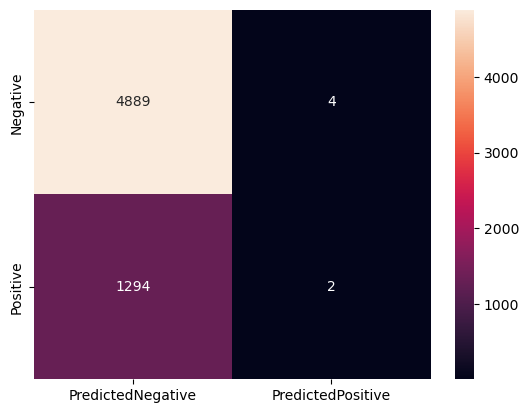

In [195]:
plot_confusion_matrix(y_test,y_pred_test)

In [196]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 20.91
Predicted Positive Percentage: 0.10
Precision TRAIN: 0.60 Precision TEST: 0.33


#### Osserviamo un elevato numero di falsi negativi

#### LOGISTIC REGRESSION MODEL WITH 0.2 THRESHOLD

#### Abbassando la soglia mi aspetto di classificare un maggior numero di positivi

In [203]:
y_pred_train=np.where(y_proba_train[:,1]>0.2,1,0) 
y_pred_test=np.where(y_proba_test[:,1]>0.2,1,0)

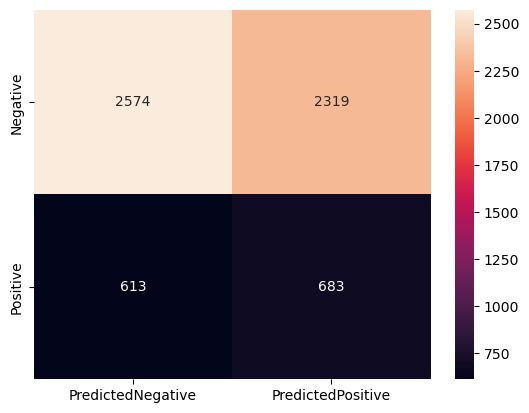

In [204]:
plot_confusion_matrix(y_test,y_pred_test)

In [205]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 9.90
Predicted Positive Percentage: 48.51
Precision TRAIN: 0.22 Precision TEST: 0.23


#### Il modello rispetta i requisiti impostati

#### LOGISTIC REGRESSION MODEL WITH 0.5 THRESHOLD AND BALANCED CLASSES

In [131]:
lr2=LogisticRegression(class_weight="balanced")

In [132]:
lr2.fit(X_train_st,y_train)
y_pred_train=lr2.predict(X_train_st)
y_proba_train=lr2.predict_proba(X_train_st)
y_pred_test=lr2.predict(X_test_st)
y_proba_test=lr2.predict_proba(X_test_st)

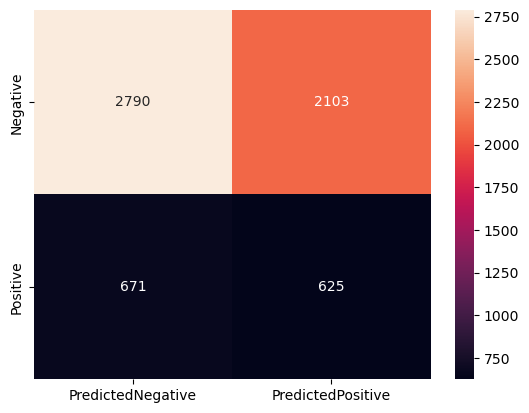

In [133]:
plot_confusion_matrix(y_test,y_pred_test)

In [134]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 10.84
Predicted Positive Percentage: 44.08
Precision TRAIN: 0.22 Precision TEST: 0.23


#### Il modello è vicino a quello richiesto, con percentuale di falsi negativi poco superiore al 10 %

### SUPPORT VECTOR MACHINES MODELS

In [135]:
from sklearn.svm import SVC

#### SVM: LINEAR KERNEL

In [136]:
svc=SVC(kernel="linear")

In [137]:
svc.fit(X_train_st,y_train)

SVC(kernel='linear')

In [138]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

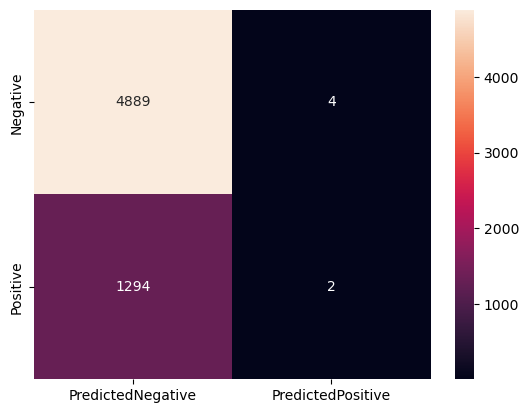

In [139]:
plot_confusion_matrix(y_test,y_pred_test)

In [140]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 20.91
Predicted Positive Percentage: 0.10
Precision TRAIN: 0.60 Precision TEST: 0.33


#### Osserviamo un elevato numero di falsi negativi

#### SVM: POLYNOMIAL KERNEL AND BALANCED CLASSES

In [141]:
svc=SVC(kernel="poly",class_weight="balanced")

In [142]:
svc.fit(X_train_st,y_train)

SVC(class_weight='balanced', kernel='poly')

In [143]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

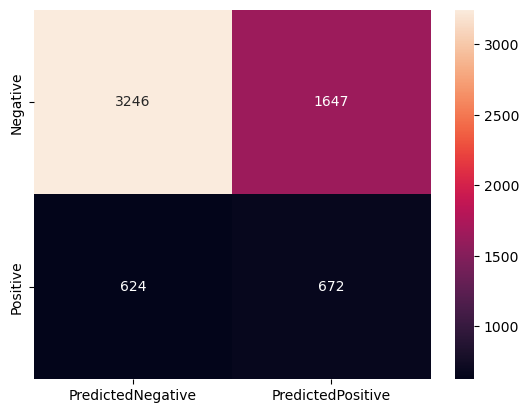

In [144]:
plot_confusion_matrix(y_test,y_pred_test)

In [145]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 10.08
Predicted Positive Percentage: 37.47
Precision TRAIN: 0.35 Precision TEST: 0.29


#### Il modello è vicino a quello richiesto, con percentuale di falsi negativi poco superiore al 10 %

#### SVM: POLYNOMIAL KERNEL, BALANCED CLASSES AND HIGHER DEGREE

In [146]:
svc=SVC(kernel="poly", class_weight="balanced", degree=5)

In [147]:
svc.fit(X_train_st,y_train)

SVC(class_weight='balanced', degree=5, kernel='poly')

In [148]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

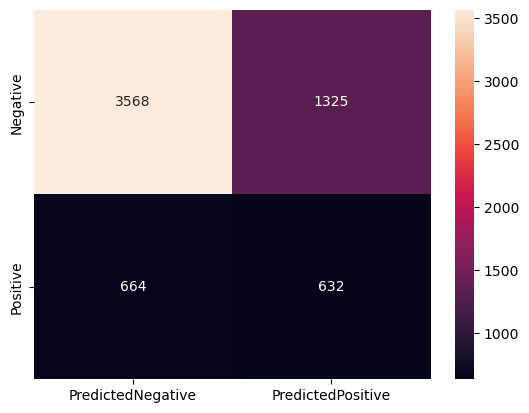

In [149]:
plot_confusion_matrix(y_test,y_pred_test)

In [150]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 10.73
Predicted Positive Percentage: 31.62
Precision TRAIN: 0.42 Precision TEST: 0.32


#### Il modello è vicino a quello richiesto, con percentuale di falsi negativi poco superiore al 10 %

#### SVM: SIGMOIDAL KERNEL AND BALANCED CLASSES

In [151]:
svc=SVC(kernel="sigmoid",class_weight="balanced")

In [152]:
svc.fit(X_train_st,y_train)

SVC(class_weight='balanced', kernel='sigmoid')

In [153]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

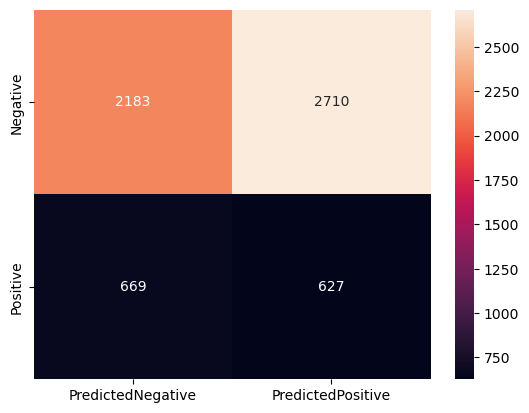

In [154]:
plot_confusion_matrix(y_test,y_pred_test)

In [155]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 10.81
Predicted Positive Percentage: 53.92
Precision TRAIN: 0.19 Precision TEST: 0.19


#### Il modello è vicino a quello richiesto, con percentuale di falsi negativi poco superiore al 10 % e percentuale di predetti positivi poco superiore al 50 %

#### SVM: GAUSSIAN KERNEL AND BALANCED CLASSES

In [156]:
svc=SVC(kernel="rbf",class_weight="balanced")

In [157]:
svc.fit(X_train_st,y_train)

SVC(class_weight='balanced')

In [158]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

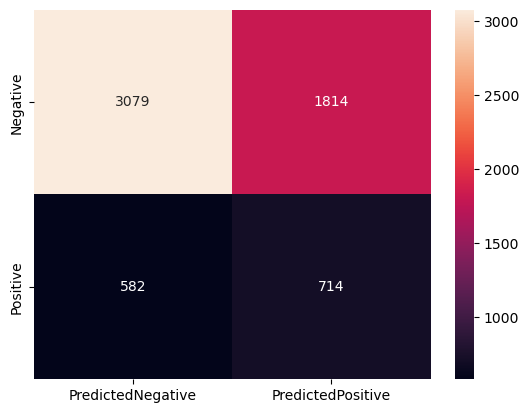

In [159]:
plot_confusion_matrix(y_test,y_pred_test)

In [160]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 9.40
Predicted Positive Percentage: 40.85
Precision TRAIN: 0.32 Precision TEST: 0.28


#### Il modello rispetta i requisiti impostati

### K-NEAREST NEIGHBORS MODEL

In [161]:
from sklearn.neighbors import KNeighborsClassifier

In [162]:
from sklearn.metrics import precision_score, recall_score

In [163]:
Ks=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]

for K in Ks:
    
    print(f"\nK={K}")
    
    knn=KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train_norm,y_train)
    
    y_pred_train=knn.predict(X_train_norm)
    
    y_pred_test=knn.predict(X_test_norm)
    
    evaluate_model(y_test,y_pred_test,y_train,y_pred_train)


K=2
False Negative Percentage: 16.69
Predicted Positive Percentage: 7.87
Precision TRAIN: 0.84 Precision TEST: 0.54

K=3
False Negative Percentage: 13.81
Predicted Positive Percentage: 15.20
Precision TRAIN: 0.70 Precision TEST: 0.47

K=4
False Negative Percentage: 16.88
Predicted Positive Percentage: 7.80
Precision TRAIN: 0.79 Precision TEST: 0.52

K=5
False Negative Percentage: 15.30
Predicted Positive Percentage: 11.86
Precision TRAIN: 0.70 Precision TEST: 0.48

K=6
False Negative Percentage: 17.34
Predicted Positive Percentage: 7.17
Precision TRAIN: 0.75 Precision TEST: 0.50

K=7
False Negative Percentage: 16.48
Predicted Positive Percentage: 9.65
Precision TRAIN: 0.69 Precision TEST: 0.46

K=8
False Negative Percentage: 18.13
Predicted Positive Percentage: 5.96
Precision TRAIN: 0.74 Precision TEST: 0.47

K=9
False Negative Percentage: 17.64
Predicted Positive Percentage: 7.53
Precision TRAIN: 0.67 Precision TEST: 0.44

K=10
False Negative Percentage: 18.55
Predicted Positive Perc

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.50 Precision TEST: 0.00

K=70


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00

K=80


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00

K=90


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00

K=100
False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Per valori di K pari o superiori a 60 otteniamo un warning sulla precision che ci avverte che i suoi numeratore e denominatore sono pari a zero, ovvero che nessuna osservazione è stata classificata come positiva: questo ha senso in quanto il dataset è sblilanciato verso la classe negativa, e, per valori grandi di K, questa risulta facilmente la classe prevalente tra i "K neighbors" e quindi quella restituita dal modello. Nessun valore di K permette di rispettare i tre requisiti richiesti: scelgo il valore che fornisce la minore false negative percentage (K=3)

In [164]:
K=3
knn=KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train_norm,y_train)
y_pred_train=knn.predict(X_train_norm)
y_pred_test=knn.predict(X_test_norm)

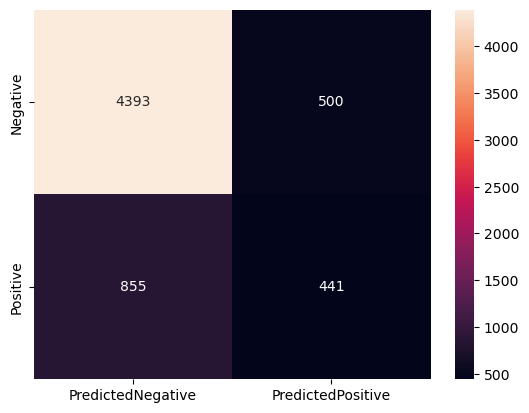

In [165]:
plot_confusion_matrix(y_test,y_pred_test)

In [166]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 13.81
Predicted Positive Percentage: 15.20
Precision TRAIN: 0.70 Precision TEST: 0.47


#### Il modello mostra una percentuale di falsi negativi poco superiore al 10 % e una precision molto superiore a 0.30

### RADIUS NEAREST NEIGHBORS MODEL

In [167]:
from sklearn.neighbors import RadiusNeighborsClassifier

In [168]:
Rs=[0.5, 1, 1.4, 1.5, 1.6, 1.7, 1.8, 2, 2.5, 3]

for R in Rs:
    
    try:
        
        print(f"\nR={R}")

        rnn=RadiusNeighborsClassifier(radius=R)
        rnn.fit(X_train_norm,y_train)


        y_pred_train=rnn.predict(X_train_norm)

        y_pred_test=rnn.predict(X_test_norm)
        
        evaluate_model(y_test,y_pred_test,y_train,y_pred_train)
        
    except ValueError as e:
        
        print("Error occurred:", e)
        continue


R=0.5
Error occurred: No neighbors found for test samples array([  57,   88,  182,  216,  222,  295,  341,  430,  449,  450,  465,
        564,  570,  576,  584,  618,  620,  688,  699,  720,  754,  815,
        844,  865,  867,  900,  965, 1024, 1080, 1112, 1141, 1176, 1187,
       1246, 1277, 1289, 1327, 1331, 1566, 1641, 1659, 1674, 1727, 1873,
       1905, 1967, 2110, 2128, 2144, 2206, 2228, 2396, 2428, 2466, 2499,
       2504, 2522, 2558, 2573, 2584, 2603, 2619, 2703, 2709, 2847, 2933,
       2962, 2966, 2971, 3059, 3067, 3199, 3250, 3373, 3396, 3411, 3545,
       3586, 3604, 3663, 3671, 3674, 3755, 3814, 3817, 3854, 3864, 3887,
       3888, 3966, 3990, 3992, 4002, 4084, 4278, 4286, 4325, 4359, 4408,
       4567, 4655, 4724, 4733, 4790, 4813, 4817, 4894, 4940, 4955, 4964,
       5049, 5105, 5118, 5223, 5301, 5352, 5391, 5407, 5463, 5466, 5487,
       5531, 5539, 5657, 5743, 5801, 5811, 5886, 5898, 5944, 5954, 5970,
       5983, 6016, 6052, 6093, 6126], dtype=int64), you can try u

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.02
Precision TRAIN: 0.00 Precision TEST: 0.00

R=2.5


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00

R=3
False Negative Percentage: 20.94
Predicted Positive Percentage: 0.00
Precision TRAIN: 0.00 Precision TEST: 0.00


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Osservo che osservazioni del test set non hanno "neighbors" a distanze basse (fino a 1.7); inoltre, su distanze alte (superiori o pari a 2), i modelli forniscono un warning sulla precision, che indica che tutte le osservazioni vengono identificate come appartententi alla classe negativa, quella più presente nel dataset; scelgo quindi R=1.8

In [169]:
R=1.8
rnn=RadiusNeighborsClassifier(radius=R)
rnn.fit(X_train_norm,y_train)
y_pred_train=rnn.predict(X_train_norm)
y_pred_test=rnn.predict(X_test_norm)

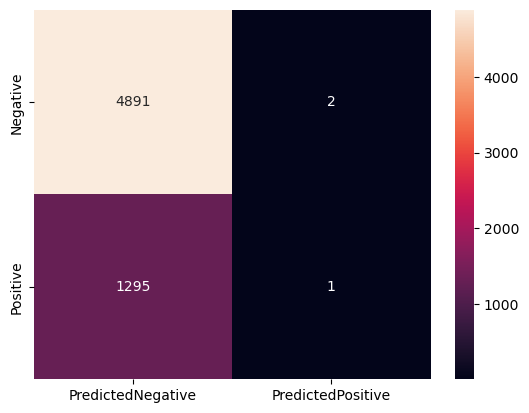

In [170]:
plot_confusion_matrix(y_test,y_pred_test)

In [171]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 20.92
Predicted Positive Percentage: 0.05
Precision TRAIN: 0.71 Precision TEST: 0.33


#### Osserviamo un elevato numero di falsi negativi

### NEURAL NETWORK MODELS

In [172]:
from sklearn.linear_model import Perceptron

#### NN: PERCEPTRON

In [206]:
p=Perceptron() 
p.fit(X_train_norm,y_train)

Perceptron()

In [174]:
y_pred_train=p.predict(X_train_norm)
y_pred_test=p.predict(X_test_norm)

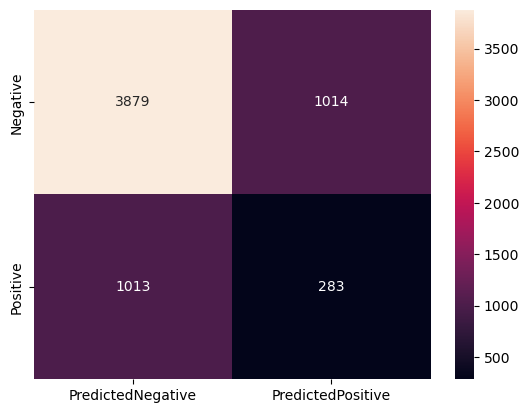

In [175]:
plot_confusion_matrix(y_test,y_pred_test)

In [176]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 16.37
Predicted Positive Percentage: 20.96
Precision TRAIN: 0.21 Precision TEST: 0.22


#### Osserviamo un elevato numero di falsi negativi

#### NN: MULTI-LAYER PERCEPTRON

In [177]:
from sklearn.neural_network import MLPClassifier

In [178]:
mlp=MLPClassifier(hidden_layer_sizes=(100, 100, 100,)) 
mlp.fit(X_train_norm,y_train)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 100, 100))

In [179]:
y_pred_train=mlp.predict(X_train_norm)
y_pred_test=mlp.predict(X_test_norm)

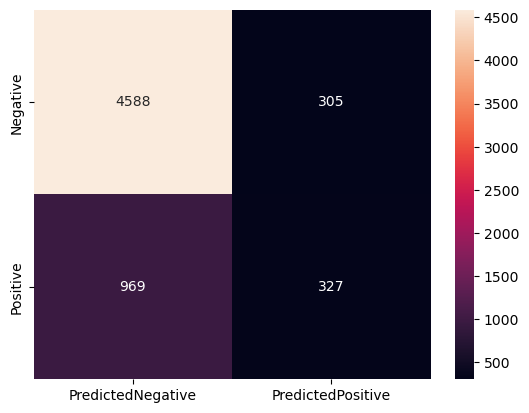

In [180]:
plot_confusion_matrix(y_test,y_pred_test)

In [181]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 15.66
Predicted Positive Percentage: 10.21
Precision TRAIN: 0.82 Precision TEST: 0.52


#### Osserviamo un elevato numero di falsi negativi

### RESULTS

#### Due modelli tra quelli creati permettono di rispettare i requisiti richiesti: 
#### 1) regressione logistica con soglia 0.2 
#### 2) support vector machines con kernel gaussiano e classi bilanciate

#### Scelgo il modello che fornisce i la maggior parte delle 3 metriche a valori inferiori, ovvero il secondo

In [182]:
svc=SVC(kernel="rbf",class_weight="balanced")

In [183]:
svc.fit(X_train_st,y_train)

SVC(class_weight='balanced')

In [184]:
y_pred_train=svc.predict(X_train_st)
y_pred_test=svc.predict(X_test_st)

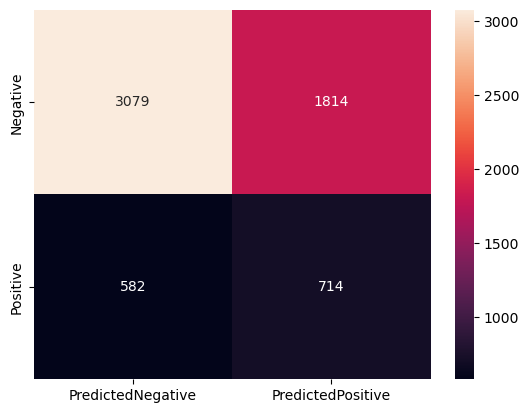

In [185]:
plot_confusion_matrix(y_test,y_pred_test)

In [186]:
evaluate_model(y_test,y_pred_test,y_train,y_pred_train)

False Negative Percentage: 9.40
Predicted Positive Percentage: 40.85
Precision TRAIN: 0.32 Precision TEST: 0.28


#### La percentuale di positivi che, secondo il modello, potrebbe ottenere la carta di credito (i falsi negativi) è pari a circa il 9%; potenzialmente questi individui accumuleranno debiti con la banca.

#### Il 41% delle persone (predetti positivi) deve essere ulteriormente analizzato prima di fornire loro una carta di credito e di queste circa il 30% non dovrebbe ricevere la carta di credito secondo il modello.